In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import neurokit2 as nk
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import mne
from sklearn.preprocessing import normalize
import torch
import ecg_plot
from utils import *


In [48]:
# important variables
PRED_LENGTH = 500 # how many samples in the future are we predicting
WINDOW_LENGTH = 2500 # how many samples we look to make predictions
LAGS = 800
TOTAL_LENGTH = PRED_LENGTH + WINDOW_LENGTH

SLIDE_SIZE = 100
INPUT_DIM = 5
OUTPUT_DIM = 5

In [49]:
# load data
file = "physionet.org/files/adfecgdb/1.0.0/r01.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
print(raw_data.shape)
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /home/amirsalimi/ECG_Nexting/physionet.org/files/adfecgdb/1.0.0/r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(5, 300000)


In [50]:
# cleanup the data
for i in range(len(raw_data)):
    raw_data[i] = nk.ecg_clean(raw_data[i],method="neurokit")

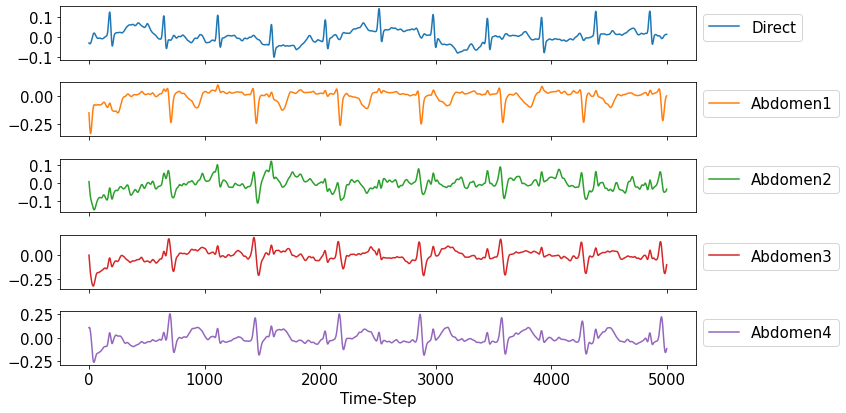

In [51]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.rcParams.update({'font.size': 15})

df = pd.DataFrame(raw_data.T,columns=["Direct","Abdomen1","Abdomen2","Abdomen3","Abdomen4"]).iloc[0:5000]

df.plot(kind="line",figsize=(12,6),xlabel="Time-Step",layout = (5,1),subplots=True,legend=True)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# for ax in plt:
#     ax.legend(bbox_to_anchor=(1.0, 1.0))
for ax in plt.gcf().get_axes():
    ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()

plt.savefig("images/ecg_example.png",bbox_inches='tight')

In [52]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, d,WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE,):
        'Initialization'
        self.data = d
        self.step_size = SLIDE_SIZE
        self.window_length = WINDOW_LENGTH
        self.pred_length = PRED_LENGTH
        self.num_windows = (d.shape[-1]-self.window_length-self.pred_length)//self.step_size
        print(d.shape[-1],self.num_windows,self.window_length,self.pred_length)
    def __len__(self):
        'Denotes the total number of samples'
        return self.num_windows

    def __getitem__(self, index):
        'Generates one sample of data'
        n = index 
        X = self.data[:,n:n+self.window_length]
        y = self.data[:,n+self.window_length:n+self.window_length+self.pred_length]
        return X, y

In [53]:
sample_size = raw_data.shape[-1]

test_portion = int(sample_size*0.90)

training_set = Dataset(raw_data[:,0:test_portion ],WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE)
training_generator = torch.utils.data.DataLoader(training_set,batch_size=1)

testing_set = Dataset(raw_data[:,test_portion :],WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE,)
testing_generator = torch.utils.data.DataLoader(testing_set,batch_size=1)

270000 2670 2500 500
30000 270 2500 500


In [54]:
past,future = testing_set[0][0],testing_set[0][1]

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
lead = 0
portion = raw_data[lead][0:4000]
df_stationarityTest = adfuller(portion,)
print("P-value: ", df_stationarityTest[1])
pacf = plot_pacf(portion, lags=1000,method = "ols")
plt.savefig("images/autolag.png")

In [ ]:
# plt.rcParams["figure.figsize"] = (15,12)
# fig, axs = plt.subplots(len(raw_data))
# for lead in range(len(raw_data)):
# #     fig.suptitle('Predicted vs Actual Lead Values')
#     ar_model = AutoReg(past[lead], lags=500).fit()
#     pred = ar_model.predict(start=WINDOW_LENGTH, end=WINDOW_LENGTH+PRED_LENGTH-1, dynamic=False)
#     axs[lead].plot(pred,label='Prediction')
#     axs[lead].plot(future[lead],label='True')
#     print(rmse_norm(pred,future[lead]))

# # fig.set_dpi(120)
# plt.legend(bbox_to_anchor=(1.2, 5.9))
# # fig.ylabel('some numbers')
# fig.show()

# calculate rmse on a moving window

In [ ]:
lead = 0
lags = 500
for lags in [50*(i+4) for i in range(20)]:
    rmse_vals = []
    past,future = testing_set[0][0],testing_set[0][1]
    ar_model = AutoReg(past[lead], lags=lags).fit()
    print(lags,end="\n")
    for i in range(len(training_set)):
        print(i,end="\r")
        past,future = training_set[i][0],training_set[i][1]
        pred = ar_model.predict(start=0, end=200-1, dynamic=False)

        rmse_vals.append(rmse_norm(pred,future[lead][0:200]))
    np.save("logs/auto_lag:%d"%(lags,),rmse_vals)
np.mean(rmse_vals)

200

2509

3009

3509

4009

4509

5009

5509

6009

6509

7009

7509

8009

8509

9009



In [119]:
df = pd.DataFrame()
for lags in [50*(i+5) for i in range(19)]:
    mv = np.load("logs/auto_lag:%d.npy"%lags)
    df[lags] = mv
df.describe()

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150
count,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000
mean,0.048033,0.069005,0.093594,0.116468,0.136193,0.136877,0.128758,0.116141,0.090528,0.073378,0.059133,0.041940,0.034163,0.035527,0.041650,0.044908,0.053331,0.058164,0.058132
std,0.011231,0.016941,0.021088,0.023202,0.023553,0.023571,0.023258,0.022947,0.023024,0.021955,0.020132,0.018815,0.016823,0.013576,0.011953,0.010544,0.010933,0.012528,0.018919
min,0.031518,0.042535,0.060565,0.078953,0.092317,0.099104,0.091968,0.079885,0.053226,0.037533,0.027892,0.009436,0.008861,0.008785,0.008701,0.007839,0.008588,0.008897,0.009085
25%,0.040668,0.058746,0.078115,0.099455,0.119051,0.119880,0.111648,0.099587,0.075760,0.058294,0.045437,0.028030,0.022680,0.024128,0.031783,0.035359,0.044922,0.049256,0.046638
50%,0.045658,0.064156,0.090578,0.113474,0.132611,0.133661,0.125339,0.113154,0.086995,0.070509,0.055483,0.037575,0.031713,0.036232,0.040317,0.046145,0.052990,0.057227,0.058268
75%,0.051796,0.074258,0.101832,0.126698,0.147222,0.148247,0.139889,0.126796,0.101094,0.084327,0.069355,0.051688,0.041618,0.042287,0.048210,0.053671,0.062653,0.069499,0.074305
max,0.081343,0.117122,0.149006,0.175171,0.195459,0.195116,0.185862,0.172025,0.146206,0.126877,0.108872,0.088858,0.077028,0.067302,0.072523,0.068001,0.078932,0.088463,0.097027


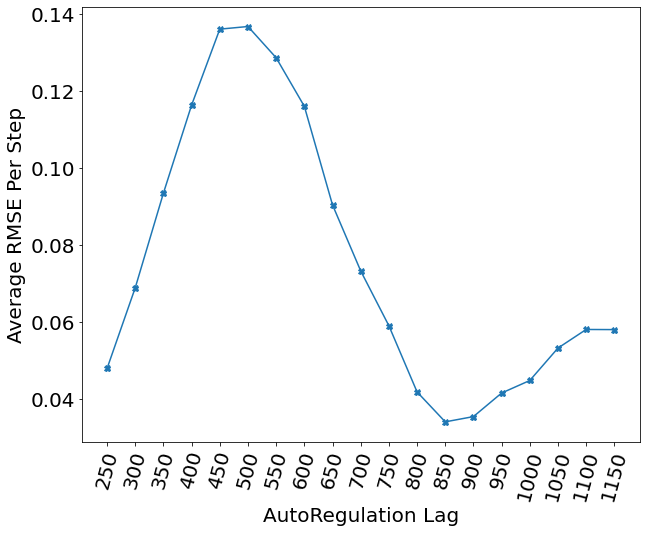

In [239]:
plt.rcParams["figure.figsize"] = (10,8)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
ax = df.mean().plot(style='X-',xticks=df.columns)
ax.set_xlabel("AutoRegulation Lag")
ax.set_ylabel("Average RMSE Per Step")
plt.xticks(rotation = 75)
plt.savefig("images/autoreg_dist.png",bbox_inches='tight')

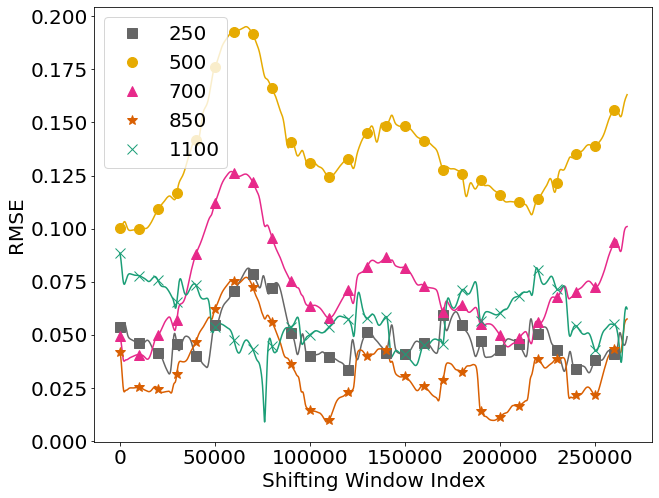

In [240]:
df2 = df.copy()
plt.rcParams["figure.figsize"] = (10,8)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rcParams.update({'font.size': 20})

df2.index = df2.index*100
cmap = "Dark2_r"
ax = df2[[250,500,700,850,1100]].plot(legend=False,colormap=cmap)
df2[[250,500,700,850,1100]][::100].plot(style=['s','o','^',"*","x"],ax=ax,colormap=cmap,markersize=10)

ax.set_xlabel("Shifting Window Index")
ax.set_ylabel("RMSE")
plt.savefig("images/autoreg_per_step.png",bbox_inches='tight')

# improving given more data

In [178]:
from pmdarima.arima import ARIMA
import statsmodels.api as sm

data = sm.datasets.sunspots.load_pandas().data['SUNACTIVITY']
data_1 = data[:len(data)//3]
data_2 = data[len(data)-len(data)//3:]

# This is the standard single fit usage
model = ARIMA(order=(12,0,0))
model.fit(data_1)

# update the model parameters with the new parameters
model.update(data_2)

/home/amirsalimi/miniconda3/envs/nexting/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(12, 0, 0))

In [113]:
X,y = training_set[0]
model = ARIMA(order=(10,0,0))
model.fit(X[0])
out = model.predict(500)
print(np.sqrt(np.mean(y-out)**2))


0.9721881990600585
